# Subset Gridded Forcing Data

To launch this notebook interactively in a Jupyter notebook-like browser interface, please click the "Launch Binder" button below. Note that Binder may take several minutes to launch.

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/hydroframe/subsettools-binder/HEAD?labpath=subsettools%2Fsubset_forcing_data.ipynb)

There are several gridded forcing data products available on HydroData.  Forcing data products are temporally complete gridded datasets of meterological variables that can be used to drive hydrologic models. Here we illustrate multiple ways to subset these datasets and create inputs for a ParFlow model or manipulate the files for other uses.

You see a complete list of the forcing data products available on HydroData [here](https://hf-hydrodata.readthedocs.io/en/latest/available_datasets.html#meteorological-forcings). Each forcing product contains at a minimum the following 8 variables: 
- Precipitation 
- Downward longwave radiation
- Downward shortwave radiation
- Specific humidity 
- Air temperature
- East/west wind speed
- North/south wind speed
- Atmospheric pressure

All forcing products are gridded and you can see the projections and spatial resolution on the HydroData documentation page. 

Note that the subset tools and HydroData API tools do not provide any re-gridding options. Data will be returned at the spatial and temporal resolution of the initial dataset which is being subset


#### Things to determine before you start
1. Before you start you should browse the [data catalog](https://hf-hydrodata.readthedocs.io/en/latest/available_data.html) and determine which forcing dataset you would like to subset. 
2. Take note of the dataset name and the grid that it is available on as you will need this information for your subsetting. 
3. Also take note of the start and end dates of the dataset as well as the temporal resolution (e.g. hourly, daily), as these will set the limits of what you can subset. 

## 1.  Setup 

In all examples you will need to import the following packages and register your pin in order to have access to the HydroData datasets

Refer to the [getting started](https://hydroframesubsettools.readthedocs.io/en/latest/getting_started.html) instructions for creating your pin if you have not done this already.

In [1]:
import subsettools as st
import hf_hydrodata as hf
from parflow.tools.io import read_pfb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

hf.register_api_pin("your_email", "your_pin")

## 2.0 Subset the forcing variables
There are two approaches to subsetting forcing data:
-  The `subset_forcing` function will automatically get the forcing data for all 8 forcing variables listed above and will write the data as pfb files into your output directory to be ready for a ParFlow run. You can modify this function to get a smaller list of variables if you would like.  
- The `hf.get_numpy` function provides more direct access to the HydroData API and can return any subset variables of interest as a numpy array. 

### 2.1 Subset forcings with the `subset_forcing` function
This approach is recommended if you are planning on using forcings for a ParFlow run. By default, `subset_forcing` will get the data for all 8 forcing variables (API reference [here](https://hydroframesubsettools.readthedocs.io/en/latest/autoapi/subsettools/index.html#subsettools.subset_forcing)) and write them out as PFBs (ParFlow Binary Files) for a ParFlow-CLM simulation. 

This function will only work with hourly forcing datasets and will default to putting 24 hours of forcing data into a file. 

In addition to writing the files out the function returns a dictionary where the keys are forcing variable names (e.g. 'precipitation', 'air_temp', ...) and the values are list of filepaths where the subset data for that variable were written. We will show how to use these paths to load the data into an array and plot them later in this tutorial.

**NOTE:** *As described above the grid that you use here must match the grid that was used to create the ij indices in step 2 and must also be consistent with the grid that the selected dataset is available on*

In [9]:
# calculate the HUC bounds
ij_huc_bounds, mask = st.define_huc_domain(hucs=["14050002"], grid="conus2")
print(f"bounding box: {ij_huc_bounds}")

bounding box: (1225, 1738, 1347, 1811)


In [11]:
# Example grabbing all 8 forcing variables
filepaths = st.subset_forcing(
    ij_huc_bounds,
    grid="conus2",
    start="2012-10-01",
    end="2013-10-01",
    dataset="CW3E",
    write_dir="/path/to/your/chosen/directory",
)

Reading precipitation pfb sequence
Reading downward_shortwave pfb sequence
Reading downward_longwave pfb sequence
Reading specific_humidity pfb sequence
Reading air_temp pfb sequence
Reading atmospheric_pressure pfb sequence
Reading east_windspeed pfb sequence
Reading north_windspeed pfb sequence
Finished writing air_temp to folder
Finished writing north_windspeed to folder
Finished writing east_windspeed to folder
Finished writing atmospheric_pressure to folder
Finished writing downward_longwave to folder
Finished writing specific_humidity to folder
Finished writing downward_shortwave to folder
Finished writing precipitation to folder


In [7]:
# Example grabbing just two forcing variables 
filepaths = st.subset_forcing(
    ij_huc_bounds,
    grid="conus2",
    start="2012-10-01",
    end="2013-10-01",
    dataset="CW3E",
    write_dir="/path/to/your/chosen/directory",
    forcing_vars=('precipitation', 'air_temp',)
)

Reading precipitation pfb sequence
Reading air_temp pfb sequence
Finished writing air_temp to folder
Finished writing precipitation to folder


### 2.2 Subset data using `gridded.get_numpy` function
The [`hf.get_numpy`](https://hf-hydrodata.readthedocs.io/en/latest/hf_hydrodata.gridded.html#hf_hydrodata.gridded.get_numpy) function is a general function to extract any gridded data from HydroData. Here we illustrate how to use it grab out a set of forcing variables. Here we show how to use this approach to grab out a single column of data but the function works the same if you provide it a bounding box. 

Note that this will just return the data as numpy array's and will not write them out for a ParFlow run so if you use this option and want to run ParFlow some additional steps will be required to write the data out. 

In [4]:
# calculate column bounds for a single point
lat = 39.8379
lon = -74.3791
# Since we want to subset only a single location, both lat-lon bounds are defined by this point:
latlon_bounds = [[lat, lon],[lat, lon]]
ij_column_bounds, _ = st.define_latlon_domain(latlon_bounds=latlon_bounds, grid="conus2")
print(f"bounding box: {ij_column_bounds}")

bounding box: (4057, 1915, 4058, 1916)


In [5]:
# list the variables that you would like to extract
forcing_vars = ('precipitation',
                'downward_shortwave',
                'downward_longwave',
                'specific_humidity',
                'air_temp',
                'atmospheric_pressure',
                'east_windspeed',
                'north_windspeed'
                )

forcing_data = {}
for var in forcing_vars:
    options = {"dataset": "CW3E",
               "grid": "conus2",
               "period": "hourly",
               "variable": var,
               "start_time": "2012-10-01",
               "end_time": "2013-10-01",
               "grid_bounds": ij_column_bounds
               }
    forcing_data[var] = hf.get_numpy(options).squeeze()
    print(f"{var} loaded:", forcing_data[var].shape)

precipitation loaded: (8760,)
downward_shortwave loaded: (8760,)
downward_longwave loaded: (8760,)
specific_humidity loaded: (8760,)
air_temp loaded: (8760,)
atmospheric_pressure loaded: (8760,)
east_windspeed loaded: (8760,)
north_windspeed loaded: (8760,)


**Saving single column subset outputs** 
Here we illustrate how to combine the single column subset values into a single dataframe and save it out as a csv. Note that this CSV is formatted to be compatible as a single column forcing file input for ParFlow. Note that ParFlow expects a specific order and format, described more in the [manual here](https://parflow.readthedocs.io/en/latest/keys.html#clm-solver-parameters).

If you subset a bounding box of data with the functions above you could use the `write_pfb` function instead to write out files for the data. 

In [6]:
# Combine in a Pandas DataFrame in the order ParFlow expects
forcing_df = pd.DataFrame({"DSWR [W/m2]": forcing_data["downward_shortwave"],
                           "DLWR [W/m2]": forcing_data["downward_longwave"],
                           "APCP [mm/s]": forcing_data["precipitation"],
                           "Temp [K]": forcing_data["air_temp"],
                           "UGRD [m/s]": forcing_data["east_windspeed"],
                           "VGRD [m/s]": forcing_data["north_windspeed"],
                           "Press [pa]": forcing_data["atmospheric_pressure"],
                           "SPFH [kg/kg]": forcing_data["specific_humidity"]
                           })

# write to a ParFlow 1D forcing file
forcing_df.to_csv('forcing1D.txt', sep=' ',header=None, index=False, index_label=False)    

## 3.0 Visualize the data 
If you use the `subset_forcing` data will need to be read in first using the `read_pfb` function. If you use `get_numpy` the data are 
already available as a numpy array. 

### 3.1 loading and visualizing data that was written out using the `subset_forcing` function
Here we use the `read_pfb` function [from PFTools](https://parflow.readthedocs.io/en/latest/python/tutorials/pfb.html#loading-pfb-from-python)  to read the subset data in and plot it. 

First, we pick a location in the chosen HUC ("14050002") and calculate the corresponding grid point for that location using the `hf.to_ij` function (API [here](https://hf-hydrodata.readthedocs.io/en/latest/hf_hydrodata.grid.html#hf_hydrodata.grid.to_ij)). We can then calculate the indices for that point in our subset data array, by subtracting the grid indices of the lower left corner:

In [16]:
# our location in the HUC
lat, lon = 40.07, -108.89
grid_i, grid_j = hf.to_ij("conus2", lat, lon)
print("grid indices grid_i, grid_j:", grid_i, grid_j)
# remember that our grid bounds for the HUC (that we calculated above) were: (imin, jmin, imax, jmax) = (1225, 1738, 1347, 1811)
# so i, j = grid_i - imin, grid_j - jmin
i, j = grid_i - 1225, grid_j - 1738
print("array indices i, j:", i, j)

grid indices grid_i, grid_j: 1230 1749
array indices i, j: 5 11


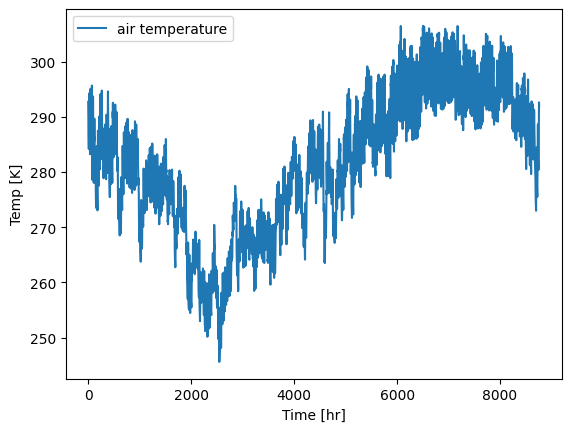

In [12]:
# Now we can concatenate all data for that point into a single array:
temp_data = np.array([])
for filepath in filepaths['air_temp']:
    data = read_pfb(filepath).squeeze()
    # select the (i, j) point calculated above:
    point_data = data[:, i, j]
    temp_data = np.concatenate((temp_data, point_data))

plt.plot(temp_data, label='air temperature')
plt.xlabel('Time [hr]')  
plt.ylabel('Temp [K]')  
plt.legend()
plt.show()

Alternatively, if we wanted to plot a forcing variable over the whole bounding box as a snapshot in time, we could do the following:

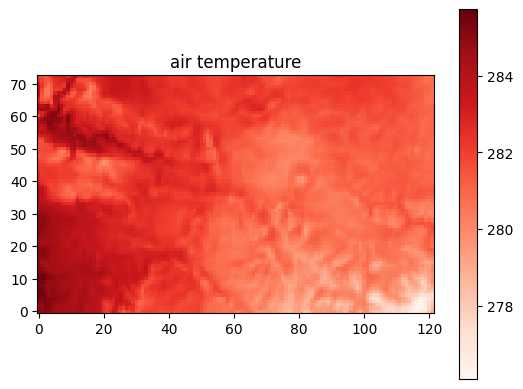

In [13]:
# here we are choosing the first day at noon for the temperature data
filename = filepaths["air_temp"][0]
data = read_pfb(filename)
plt.imshow(data[12, :, :], cmap="Reds", origin='lower')
plt.title("air temperature")
plt.colorbar()

### 3.2 Visualize data that was subset using `gridded.get_numpy`
Here we just visualize directly from the dataframe that was created in section 2.2. Note that you can also visualize your data from the numpy arrays directly and don't need to convert to a dataframe if you don't want to. 

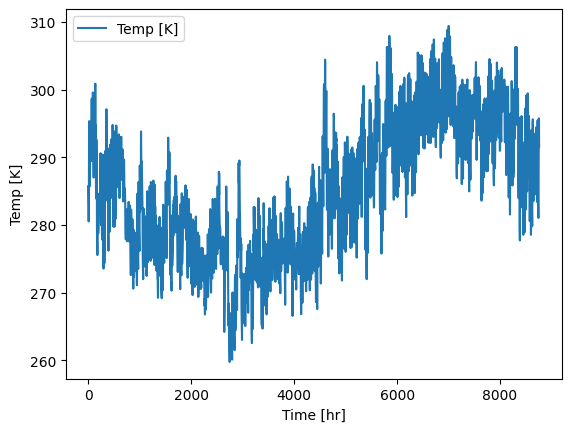

In [14]:
plt.plot(forcing_df['Temp [K]'], label='Temp [K]')
plt.xlabel('Time [hr]')  
plt.ylabel('Temp [K]')  
plt.legend()
plt.show()

## 4. Cite the data sources

Please make sure to cite all data sources that you use. We will use the `get_citations` function, which takes as an argument a dataset name and returns citation information about that dataset:

In [15]:
hf.get_citations("CW3E")

'Meteorological Forcing Data for Conus2 Grid\n  Source: https://cw3e.ucsd.edu\n'